1. In this notebook, the [Sentiment140 dataset with 1.6 million tweets](https://www.kaggle.com/kazanova/sentiment140)from kaggle will be usded. 
2. A pre-trained word vectors (embedded layer) will be used to conduct the transfer learning. --- [GloVe: Global Vectors for Word Representation](https://nlp.stanford.edu/projects/glove/)

# Import Data

In [1]:
import json
import tensorflow as tf
import csv
import random
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers

In [2]:
embedding_dim = 100
max_len = 16
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"
training_size=160000
test_portion = .1

corpus = []

In [3]:
# A cleaner vision of the data, where the LATIN1 encoding was removed, easier for csv reader to read
# how to achieve that:
      #iconv -f LATIN1 -t UTF8 training.1600000.processed.noemoticon.csv -o training_cleaned.csv

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv \
    -O /tmp/training_cleaned.csv

--2020-08-28 18:48:52--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 238942690 (228M) [application/octet-stream]
Saving to: ‘/tmp/training_cleaned.csv’

/tmp/training_clean 100%[===================>] 227.87M   163MB/s    in 1.4s    

2020-08-28 18:48:54 (163 MB/s) - ‘/tmp/training_cleaned.csv’ saved [238942690/238942690]



In [4]:
num_sentences = 0

with open("/tmp/training_cleaned.csv") as csvfile:
  reader = csv.reader(csvfile, delimiter = ',')
  for row in reader:
    list_item=[]
    # Create list items where the first item is the text, found in row[5], and the second is the label. Note that the label is a '0' or a '4' in the text. When it's the former, make
    #  label to be 0, otherwise 1. Keep a count of the number of sentences in num_sentences
    list_item.append(row[5])
    this_label=row[0]
    if this_label=='0':
        list_item.append(0)
    else:
        list_item.append(1)
    num_sentences = num_sentences + 1
    corpus.append(list_item)


In [5]:
print(num_sentences)
print(len(corpus))
print(corpus[12])

1600000
1600000
["@caregiving I couldn't bear to watch it.  And I thought the UA loss was embarrassing . . . . .", 0]


# Tokenizing

In [6]:
sentences = []
labels = []
random.shuffle(corpus)

# take numbers == training_size of sentences with lables out of corpus
for i in range(training_size):
  sentences.append(corpus[i][0])
  labels.append(corpus[i][1])


In [7]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

word_index = tokenizer.word_index
vocab_size=len(word_index)

sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

test_num = int(test_portion * training_size)

test_sequences = padded[:test_num]
train_sequences = padded[test_num:training_size]
test_labels = labels[0:test_num]
train_labels = labels[test_num:training_size]

In [8]:
print(vocab_size)
print(word_index['w'])

138784
275


In [9]:
# Note this is the 100 dimension version of GloVe from Stanford
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt

--2020-08-28 18:49:16--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 172.253.117.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: ‘/tmp/glove.6B.100d.txt’

/tmp/glove.6B.100d. 100%[===================>] 331.04M   210MB/s    in 1.6s    

2020-08-28 18:49:18 (210 MB/s) - ‘/tmp/glove.6B.100d.txt’ saved [347116733/347116733]



In [11]:
# dic to hold the pairs of words and vectors
embeddings_index = {}

with open('/tmp/glove.6B.100d.txt') as f:
  for line in f:
    values = line.split()
    word = values[0] # word
    coefs = np.asarray(values[1:], dtype='float32') # vector coefficient: pre trained
    embeddings_index[word] = coefs

# Matrix will be the input of embedded layer
embeddings_matrix = np.zeros((vocab_size+1, embedding_dim)) # vocab_size + 1 because we didnt include OOV case in the tokenizer. If included, then no need to +1
for word, i in word_index.items():
  # get the coefs vector of each word
  embeddings_vector = embeddings_index.get(word)
  if embeddings_vector is not None: # not OOV
    embeddings_matrix[i] = embeddings_vector

In [12]:
print(len(embeddings_matrix))

138785


# Create Model

In [14]:
model = tf.keras.Sequential([
    # use pre-trained coefs as weights, and freeze embedding layer
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_len, weights=[embeddings_matrix], trainable=False), 
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


In [15]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 16, 100)           13878500  
_________________________________________________________________
dropout (Dropout)            (None, 16, 100)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 12, 64)            32064     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 3, 64)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 13,943,653
Trainable params: 65,153
Non-trainable params: 13,878,500
_______________________________________

In [20]:
num_epochs = 50

training_padded = np.array(train_sequences) # turn list to np.array
training_labels = np.array(train_labels)
testing_padded = np.array(test_sequences)
testing_labels = np.array(test_labels)

history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=1)

Epoch 1/50
4500/4500 [==============================] - 16s 4ms/step - loss: 0.4370 - accuracy: 0.7897 - val_loss: 0.5113 - val_accuracy: 0.7509
Epoch 2/50
4500/4500 [==============================] - 16s 4ms/step - loss: 0.4370 - accuracy: 0.7903 - val_loss: 0.5111 - val_accuracy: 0.7508
Epoch 3/50
4500/4500 [==============================] - 16s 4ms/step - loss: 0.4354 - accuracy: 0.7911 - val_loss: 0.5101 - val_accuracy: 0.7475
Epoch 4/50
4500/4500 [==============================] - 16s 4ms/step - loss: 0.4339 - accuracy: 0.7920 - val_loss: 0.5152 - val_accuracy: 0.7492
Epoch 5/50
4500/4500 [==============================] - 16s 4ms/step - loss: 0.4332 - accuracy: 0.7926 - val_loss: 0.5125 - val_accuracy: 0.7516
Epoch 6/50
4500/4500 [==============================] - 16s 4ms/step - loss: 0.4331 - accuracy: 0.7927 - val_loss: 0.5169 - val_accuracy: 0.7449
Epoch 7/50
4500/4500 [==============================] - 16s 4ms/step - loss: 0.4332 - accuracy: 0.7931 - val_loss: 0.5161 - val_ac

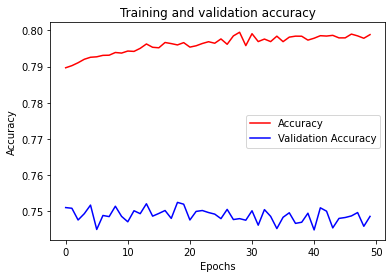

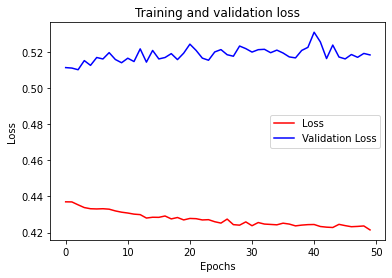

In [21]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

plt.figure()

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])



plt.figure()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])



